In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

# Na channel recovery from inactivation

## 1. Choose the data file you want to analyze

In [ ]:
pathToData = "data/"
data_folders = glob(pathToData+"*") # The glob function helps you filter your files
print("Data folders:")
data_folders

Data folders:


['data/Fig_Nav',
 'data/single_channel_recordings',
 'data/Fig_Cav',
 'data/example_HEKA.dat',
 'data/link_to_data.txt',
 'data/Fig_Kv']

In [3]:
data_files = glob(data_folders[0]+"/*.abf")
print(data_folders[0])
data_files

data/Fig_Nav


['data/Fig_Nav/nav18-iv.abf',
 'data/Fig_Nav/nav18-ssinact.abf',
 'data/Fig_Nav/nav18-nav_recovery.abf',
 'data/Fig_Nav/NAV_Tho(1)_21309013.abf',
 'data/Fig_Nav/NAV_Cerv(3)_22712021.abf',
 'data/Fig_Nav/NAV_Tho(2)_21309018.abf',
 'data/Fig_Nav/NAV_Cerv(1)_22712019.abf',
 'data/Fig_Nav/NAV_Cerv(2)_22712020.abf',
 'data/Fig_Nav/NAV_Lomb(1)_22919024.abf',
 'data/Fig_Nav/NAV_Lomb(2)_22919023.abf']

In [4]:
data_file = 'data/Fig_Nav/nav18-ssinact.abf'

In [ ]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(sweeps.shape)
print(sweeps_time.shape)
print(f"freq: {sampling_freq} Hz")

(40, 2, 55000)
(55000,)
freq: 99999.99999999999 Hz


## 2. Plot the traces to get an overview of the data

array([<Axes: ylabel='Current (pA)'>,
       <Axes: xlabel='Time (ms)', ylabel='Voltage (mV)'>], dtype=object)

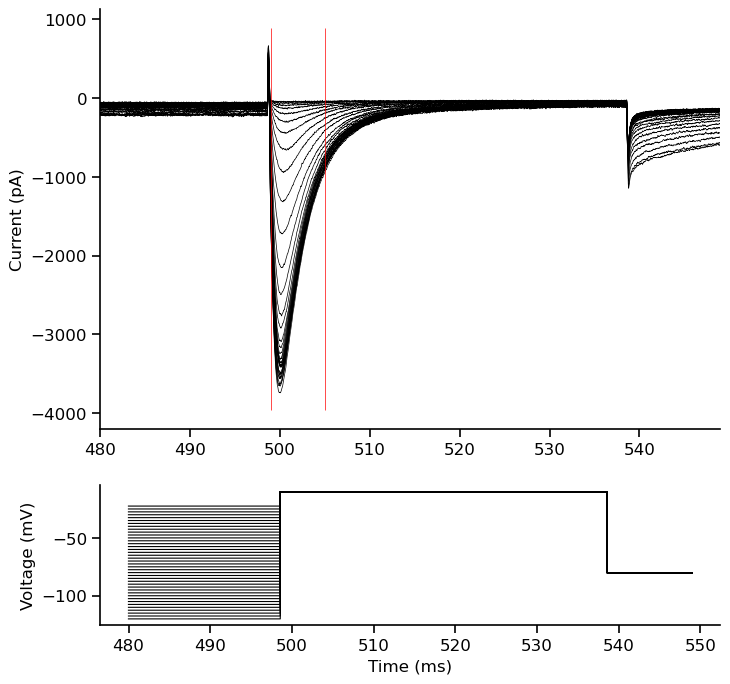

In [6]:
start_time = 480 # milliseconds
end_time = -1 # milliseconds

# marker_1 = None
# marker_2 = None
marker_1 = 499 # milliseconds
marker_2 = 505 # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)

## 3. Select what you want to measure:
- define the time window(s) of interest
- define what you want to measure (e.g. mean or peak voltage/current)

### 3.1. Optional: apply baseline correction

In [7]:
# # 1. Measure baseline
# start_time = 0 # milliseconds
# end_time = 0.5 # milliseconds
# measurement_type = 'mean' # Options: 'mean', 'max', 'min'

# baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)

# num_traces = sweeps.shape[0]
# for i in range(num_traces):
#     # sweeps[i,1] -= baseline_voltage[i]
#     sweeps[i,0] -= baseline_current[i]

# plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)

### 3.2. Measure currents/voltage steps

Sigmoid Fit parameters:
ymax: -0.985, ymin: 0.993, x_half: -49.900, slope: 0.193


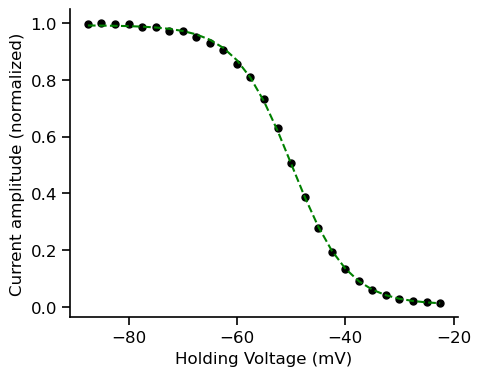

In [44]:
start_time = marker_1 # milliseconds
end_time = marker_2 # milliseconds
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

_, current_steps = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)

# Here we want to measure the holding voltages in the first phase of the step protocol.
voltage_steps, _ = get_step_measurements(sweeps, sweeps_time, start_time=480, end_time=490, sampling_freq=sampling_freq, measurement_type='mean')

# Remove bad sweeps
current_steps = current_steps[13:]
voltage_steps = voltage_steps[13:]

# Normalize to the biggest current
current_steps /= np.min(current_steps)  # Normalize current steps to the minimum value

# Plot the normalized current steps against the holding voltages
plt.figure(figsize=(5, 4))
plt.plot(voltage_steps, current_steps, 'o', color='black', markersize=5)
plt.xlabel('Holding Voltage (mV)')
plt.ylabel('Current amplitude (normalized)')

# Optional: fit a sigmoid to the points
from scipy.optimize import curve_fit
def sigmoid(x, ymax, x0, slope, ymin):
    return ymax / (1 + np.exp(-slope * (x - x0))) + ymin
p0 = [max(current_steps), np.median(voltage_steps), 1, min(current_steps)]
popt, pcov = curve_fit(sigmoid, voltage_steps, current_steps, p0=p0)
plt.plot(voltage_steps, sigmoid(voltage_steps, *popt), linestyle='--', color='g', label='Fit')
print("Sigmoid Fit parameters:")
print(f"ymax: {popt[0]:.3f}, ymin: {popt[3]:.3f}, x_half: {popt[1]:.3f}, slope: {popt[2]:.3f}")


### Optional: fit single exponential to voltage traces to get tau

In [ ]:
#Fit single exponential to voltage traces to get tau
start_time = 40 # milliseconds
end_time = 180 # milliseconds

marker_1 = 56 # milliseconds
marker_2 = 150 # milliseconds

voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)
ax = plot_traces(time_in_window, voltage_traces, current_traces, marker_1, marker_2)

tau_values, ax = plot_expontial_fit(sweeps, sweeps_time, marker_1, marker_2, sampling_freq, ax=ax)